In [ ]:
pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=c7418b1309287df50607eedbcb95baa53f53a42c25fea7b4082986cac93127d7
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AirQualityUCI.csv to AirQualityUCI (1).csv
Saving AirQualityUCI.xlsx to AirQualityUCI.xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer

from scipy.stats import skew, kurtosis, shapiro,zscore
from scipy import stats
from pyod.models.mad import MAD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import (
    PowerTransformer,
    PolynomialFeatures,
    QuantileTransformer
)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

df = pd.read_csv('AirQualityUCI.csv', sep=';')

object_columns = df.select_dtypes(include=['object']).columns


for col in object_columns[2:]:
        try:
            # Clean the column first
            df[col] = df[col].str.replace(',', '.').str.replace(' ', '')

            # Convert to numeric, coercing errors to NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception as e:
            print(f"Could not convert {col}: {e}")


print(df.dtypes)

def clean_dataframe(df):
    # Drop columns that are completely empty (all NaN)
    df = df.dropna(axis=1, how='all')

    # Drop unnamed columns that are empty or nearly empty
    unnamed_cols = [col for col in df.columns if 'Unnamed:' in str(col)]
    for col in unnamed_cols:
        if df[col].isna().sum() / len(df) > 0.99:  # If more than 99% is NaN
            df = df.drop(columns=[col])

    return df

df = clean_dataframe(df)

Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
Unnamed: 15      float64
Unnamed: 16      float64
dtype: object


In [ ]:
#DATA PREPARATION

In [ ]:


print(df.isnull().sum())


numerical_features = df.select_dtypes(include = ['int64','float64']).columns.values
categorical_features = df.select_dtypes(include = ['object']).columns.values

df[numerical_features] = df[numerical_features].replace(-200, np.nan)


cat_impute = SimpleImputer(strategy='constant', fill_value = 'missing')


df[categorical_features] = cat_impute.fit_transform(df[categorical_features])

print(df[categorical_features].isnull().sum())


scaler = MinMaxScaler()
num_impute = KNNImputer()

normalized_numerical = scaler.fit_transform(df[numerical_features])
imputed_numerical = num_impute.fit_transform(normalized_numerical)

df[numerical_features] = pd.DataFrame(
    scaler.inverse_transform(imputed_numerical),
    columns=numerical_features
)

print(df.isnull().sum())
print()


#Explanation:
# Handling categorical features with SimpleImputer because categorical features typically represent discrete labels or categories and
# imputing missing values ensures that these features remain interpretable and consistent with their original type
# Handling numerical features with KNNImputer because numerical features have patterns and correlations with other features, making KNN a robust choice for imputing missing values.
# KNN identifies the k nearest neighbors based on feature similarity and imputes missing values as a weighted average of these neighbors.
# This approach captures underlying patterns in the data better than simpler methods like mean or median imputation.
# KNN calcualtes distances between data points to determine which neighbors are closest.Features with larger ranges can dominate these distance calculations, leading to biased imputations.
# MinMaxScaler ensures all features contribute equally by rescaling them to a uniform range, typically [0,1]



Date             114
Time             114
CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
dtype: int64
Date    0
Time    0
dtype: int64
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64



In [ ]:
# EDA

In [ ]:

def load_and_initial_info(df):
    """
    Display initial information about the dataset
    """
    print("Dataset Shape:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nMemory Usage:\n", df.memory_usage(deep=True))


def detect_anomalies(data):
    # List of numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    results = {}
    cleaned_data = data.copy()

    for column in numeric_cols:
        try:
            # Data preparation
            X = data[[column]].copy()

            # Fixing NaN values
            X = X.fillna(X.median())

            # Normalization of data before anomaly detection
            mean_val = X[column].mean()
            std_val = X[column].std()

            if std_val == 0:
                # If the standard deviation is zero, use the simpler method
                # Mark as anomalies values ​​that differ from the median by more than 3 IQR
                Q1 = X[column].quantile(0.25)
                Q3 = X[column].quantile(0.75)
                IQR = Q3 - Q1
                if IQR == 0:
                    # If IQR is zero, all values ​​are normal
                    labels = np.zeros(len(X))
                else:
                    lower_bound = Q1 - 3 * IQR
                    upper_bound = Q3 + 3 * IQR
                    labels = ((X[column] < lower_bound) | (X[column] > upper_bound)).astype(int)
            else:
                # Data normalization
                X_norm = (X - X.mean()) / X.std()
                try:
                    mad = MAD().fit(X_norm)
                    labels = mad.labels_
                except:
                    # In case of MAD error, use the standard deviation method
                    labels = (np.abs(X_norm) > 3).astype(int)

            # Anomaly count
            anomaly_counts = pd.Series(labels).value_counts()

            # Save results
            results[column] = {
                'total_records': len(data),
                'normal_records': anomaly_counts.get(0, 0),
                'anomalies': anomaly_counts.get(1, 0),
                'anomaly_percentage': (anomaly_counts.get(1, 0) / len(data)) * 100,
                'statistics': {
                    'mean': X[column].mean(),
                    'median': X[column].median(),
                    'std': X[column].std(),
                    'min': X[column].min(),
                    'max': X[column].max()
                }
            }

            # Adding a column with information about anomalies
            cleaned_data[f'{column}_is_anomaly'] = labels

        except Exception as e:
            print(f"Error parsing column {column}: {str(e)}")
            continue


    return results, cleaned_data

def univariate_analysis_numeric(df):
    """
    Perform univariate analysis on numeric columns with proper error handling

    Parameters:
    df (pandas.DataFrame): Input dataframe

    Returns:
    pandas.DataFrame: Descriptive statistics for numeric columns
    """
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    if len(numeric_cols) == 0:
        print("No numeric columns found in the dataset")
        return None

    # Descriptive statistics
    stats_df = df[numeric_cols].describe()
    stats_df.loc['skewness'] = df[numeric_cols].skew()
    stats_df.loc['kurtosis'] = df[numeric_cols].kurtosis()

    # Create plots for each numeric column
    for col in numeric_cols:
        # Skip if column is empty or all values are null
        if df[col].empty or df[col].isna().all():
            print(f"Skipping {col} - No valid data found")
            continue

        try:
            plt.figure(figsize=(12, 4))

            # Distribution plot
            plt.subplot(1, 3, 1)
            sns.histplot(data=df, x=col, kde=True)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45)

            # Box plot - using sns.boxplot instead of plt.boxplot for better handling
            plt.subplot(1, 3, 2)
            sns.boxplot(data=df, y=col)
            plt.title(f'Box Plot of {col}')

            # Q-Q plot
            plt.subplot(1, 3, 3)
            # Drop NaN values and check if we have enough data
            valid_data = df[col].dropna()
            if len(valid_data) > 1:  # Need at least 2 points for Q-Q plot
                stats.probplot(valid_data, dist="norm", plot=plt)
                plt.title(f'Q-Q Plot of {col}')
            else:
                plt.text(0.5, 0.5, 'Insufficient data\nfor Q-Q plot',
                        ha='center', va='center')
                plt.title(f'Q-Q Plot of {col} (N/A)')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error plotting {col}: {str(e)}")
            plt.close()  # Close the figure in case of error
            continue

    return stats_df

def univariate_analysis_categorical(df, max_categories=15, figsize=(15, 6), min_percentage=1):
    """
    Perform univariate analysis on categorical columns with improved readability

    Parameters:
    df (pandas.DataFrame): Input dataframe
    max_categories (int): Maximum number of categories to show in plots (default: 15)
    figsize (tuple): Figure size for plots (default: (15, 6))
    min_percentage (float): Minimum percentage to show as separate category (default: 1)
    """
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if len(categorical_cols) == 0:
        print("No categorical columns found in the dataset")
        return

    for col in categorical_cols:
        try:
            # Skip if column is empty or all values are null
            if df[col].empty or df[col].isna().all():
                print(f"Skipping {col} - No valid data found")
                continue

            # Calculate value counts and percentages
            value_counts = df[col].value_counts()
            value_percentages = df[col].value_counts(normalize=True) * 100

            # Group small categories into "Others"
            if len(value_counts) > max_categories or (value_percentages < min_percentage).any():
                # Keep top categories and group others
                top_categories = value_percentages[value_percentages >= min_percentage].head(max_categories)
                others_percentage = value_percentages[~value_percentages.index.isin(top_categories.index)].sum()
                others_count = value_counts[~value_counts.index.isin(top_categories.index)].sum()

                if others_percentage > 0:
                    value_counts = value_counts[top_categories.index].copy()
                    value_counts['Others'] = others_count
                    value_percentages = value_percentages[top_categories.index].copy()
                    value_percentages['Others'] = others_percentage

            # Plotting
            plt.figure(figsize=figsize)

            # Bar plot with improved readability
            plt.subplot(1, 2, 1)
            bars = sns.barplot(x=value_counts.values, y=value_counts.index, orient='h')
            plt.title(f'Frequency Distribution of {col}')

            # Add value labels to bars
            for i, v in enumerate(value_counts.values):
                bars.text(v, i, f' {v:,}', va='center')

            # Adjust layout for long category names
            plt.margins(x=0.2)

            # Pie chart with improved readability
            plt.subplot(1, 2, 2)
            colors = sns.color_palette("husl", n_colors=len(value_percentages))
            wedges, texts, autotexts = plt.pie(value_percentages,
                                             labels=value_percentages.index,
                                             colors=colors,
                                             autopct='%1.1f%%',
                                             pctdistance=0.85)

            # Enhance pie chart readability
            plt.setp(autotexts, size=8, weight="bold")
            plt.setp(texts, size=8)

            # Add a title
            plt.title(f'Percentage Distribution of {col}')

            # Adjust layout
            plt.tight_layout()
            plt.show()

            # Print statistics with improved formatting
            stats_df = pd.DataFrame({
                'Count': value_counts,
                'Percentage': value_percentages
            })
            stats_df['Percentage'] = stats_df['Percentage'].round(2)

            print(f"\nValue Counts for {col}:")
            print("Total unique values:", len(df[col].unique()))
            print("Number of null values:", df[col].isnull().sum())
            print("\nTop categories distribution:")
            print(stats_df.to_string(float_format=lambda x: '{:,.2f}'.format(x)))

            # Add extra information if categories were grouped
            if 'Others' in value_counts:
                print(f"\nNote: {len(df[col].unique()) - len(value_counts) + 1:,} categories were grouped into 'Others'")

            print("\n" + "="*50 + "\n")

        except Exception as e:
            print(f"Error analyzing {col}: {str(e)}")
            plt.close()  # Close the figure in case of error
            continue

In [ ]:
def calculate_eta_squared(df, cat_col, num_col):
    """
    Calculate eta-squared (a measure of association) between a categorical and a numeric column.
    """
    groups = [df[num_col][df[cat_col] == category] for category in df[cat_col].unique()]
    ss_between = sum(len(group) * (group.mean() - df[num_col].mean())**2 for group in groups)
    ss_total = sum((df[num_col] - df[num_col].mean())**2)
    eta_squared = ss_between / ss_total if ss_total != 0 else 0
    return eta_squared

def multivariate_analysis(df):
    """
    Perform multivariate analysis with numeric and categorical data
    """
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # 1. Correlation matrix for numeric data
    if len(numeric_cols) > 1:
        plt.figure(figsize=(12, 8))
        correlation_matrix = df[numeric_cols].corr()
        high_corr_pairs = correlation_matrix[(correlation_matrix.abs() > 0.7) & (correlation_matrix != 1)]
        sns.heatmap(high_corr_pairs, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix for Numeric Data')
        plt.tight_layout()
        plt.show()

    # 2. Scatter plot matrix for selected numeric features
    if len(numeric_cols) > 1:
        selected_cols = numeric_cols[:4] if len(numeric_cols) > 4 else numeric_cols
        sns.pairplot(df[selected_cols])
        plt.tight_layout()
        plt.show()

    # 3. Correlation (Cramér's V) for categorical data
    if len(categorical_cols) > 1:
        cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                                        index=categorical_cols, columns=categorical_cols)
        for col1 in categorical_cols:
            for col2 in categorical_cols:
                if col1 != col2:
                    confusion_matrix = pd.crosstab(df[col1], df[col2])
                    chi2 = stats.chi2_contingency(confusion_matrix)[0]
                    n = confusion_matrix.sum().sum()
                    r, k = confusion_matrix.shape
                    cramers_v_matrix.loc[col1, col2] = np.sqrt(chi2 / (n * (min(r, k) - 1)))

        plt.figure(figsize=(12, 8))
        sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title("Cramér's V Matrix for Categorical Data")
        plt.tight_layout()
        plt.show()



def analyze_missing_values(df):
    """
    Helper function to analyze missing values in the dataset
    """
    missing_summary = {
        'missing_counts': df.isnull().sum(),
        'missing_percentages': (df.isnull().sum() / len(df) * 100).round(2),
        'total_missing': df.isnull().sum().sum()
    }
    return missing_summary




def feature_engineering(df, correlation_threshold=0.8):
    """
    Create new features based on correlations between numeric features and analyze their relationships

    Parameters:
    -----------
    df : pandas DataFrame
        The input data with features
    correlation_threshold : float, optional (default=0.8)
        The threshold for identifying highly correlated feature pairs

    Returns:
    --------
    pandas DataFrame with new features added
    """
    # Identify numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Temporary DataFrame for new columns
    new_features = pd.DataFrame(index=df.index)

    # 1. Create new feature based on interaction between 'C6H6(GT)' and 'AH'
    new_features['C6H6_GT_x_AH'] = df['C6H6(GT)'] * df['AH']

    # 2. Calculate correlation matrix and identify highly correlated pairs
    correlation_matrix = df[numeric_cols].corr()
    correlated_pairs = []

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                correlated_pairs.append((col1, col2))

    # 3. Create new features from highly correlated pairs
    for col1, col2 in correlated_pairs:
        new_features[f'{col1}_plus_{col2}'] = df[col1] + df[col2]  # Add
        new_features[f'{col1}_minus_{col2}'] = df[col1] - df[col2]  # Subtract
        new_features[f'{col1}_times_{col2}'] = df[col1] * df[col2]  # Multiply
        new_features[f'{col1}_div_{col2}'] = df[col1] / df[col2].replace(0, np.nan)  # Divide

    # 4. Statistical aggregations
    new_features['numeric_mean'] = df[numeric_cols].mean(axis=1)
    new_features['numeric_std'] = df[numeric_cols].std(axis=1)

    # 5. Normalization and scaling
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numeric_cols])
    scaled_df = pd.DataFrame(scaled_data, columns=[f'{col}_std' for col in numeric_cols], index=df.index)
    new_features = pd.concat([new_features, scaled_df], axis=1)

    # 6. Feature interactions (e.g., products)
    products = {
        f'{col1}_x_{col2}': df[col1] * df[col2]
        for i, col1 in enumerate(numeric_cols) for j, col2 in enumerate(numeric_cols) if i < j
    }
    new_features = pd.concat([new_features, pd.DataFrame(products)], axis=1)


    # 8. PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(df[numeric_cols])
    new_features['pca_1'], new_features['pca_2'] = pca_features[:, 0], pca_features[:, 1]

    # Connect the original DataFrame to the new columns
    df = pd.concat([df, new_features], axis=1)

    return df


def describe_engineered_features(df_original, df_engineered):
    """
    Provide detailed explanation of the engineered features
    """
    new_features = set(df_engineered.columns) - set(df_original.columns)
    print("\nFeature Engineering Summary:")
    print(f"Created {len(new_features)} new features:")
    for feature in new_features:
        if 'ratio' in feature:
            print(f"- {feature}: Ratio feature showing relative values")
        elif 'rate' in feature:
            print(f"- {feature}: Rate feature showing temporal patterns")
        elif '_x_' in feature:
            print(f"- {feature}: Interaction feature capturing combined effects")
        elif 'pca' in feature:
            print(f"- {feature}: Principal component capturing variance in related features")
        elif 'scaled' in feature:
            print(f"- {feature}: Standardized version of original feature")
    return list(new_features)

In [ ]:


print("=== Initial Data Information ===")
load_and_initial_info(df)

results, cleaned_df = detect_anomalies(df)

print("\nAnomaly detection results:")
print("-" * 50)
for column, result in results.items():
    print(f"\nColumn: {column}")
    print(f"Total records: {result['total_records']}")
    print(f"Normal records: {result['normal_records']}")
    print(f"Anomalies: {result['anomalies']} ({result['anomaly_percentage']:.2f}%)")
    print("Statistics:")
    for stat_name, value in result['statistics'].items():
        print(f"  {stat_name}: {value:.2f}")

print("\n=== Univariate Analysis - Numeric Features ===")
stats_df = univariate_analysis_numeric(df)
print("\nDescriptive Statistics:")
print(stats_df)

print("\n=== Univariate Analysis - Categorical Features ===")
univariate_analysis_categorical(df,
                              max_categories=10,
                              figsize=(18, 7),
                              min_percentage=2)

print("\n=== Multivariate Analysis ===")
multivariate_analysis(df)

print("\n=== Feature Engineering and Additional Analysis ===")
df_engineered = feature_engineering(df)
print("New features created. Running correlation analysis with new features...")
multivariate_analysis(df_engineered)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Feature engineering - basic transformations (nonlinear)

In [ ]:

# Compute skewness for numerical features
skewed_features = numerical_features[df[numerical_features].skew().abs()> 0.5]

print(df[numerical_features].dtypes)

# Check for non-positive values before applying transformations
for feature in skewed_features:
    if (df[feature] <= 0).any():
        print(f"Feature {feature} contains non-positive values. Log transformation skipped.")
    else:
        df[f'log_{feature}'] = np.log1p(df[feature])  # Apply log transformation

    if (df[feature] < 0).any():
        print(f"Feature {feature} contains negative values. Square root transformation skipped.")
    else:
        df[f'sqrt_{feature}'] = np.sqrt(df[feature])  # Apply square root transformation

# Generate polynomial features for specific features
selected_features = ['PT08.S2(NMHC)', 'PT08.S1(CO)']
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[selected_features])
poly_feature_names = poly.get_feature_names_out(selected_features)

# Add polynomial features back to the DataFrame
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
df = pd.concat([df, df_poly], axis=1)

print(df.head())

# I have choose PT08.S2(NMHC) and PT08.S1(CO) because of high correlation between them


CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object
         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  ...  sqrt_PT08.S3(NOx)  \
0         1046.0    166.0        1056.0    113.0  ...          32.496154   
1          955.0    103.0        1174.0     92.0  ...          34.263683   
2          939.0    131.

In [ ]:

#Baseline model - linear regression without regularization
#Evaluation:
#Metrics chosen as well as reasoning behind each metric
#Residual analysis was done and conclusions were drawn
#Hyperparameters tuning
#Feature importance


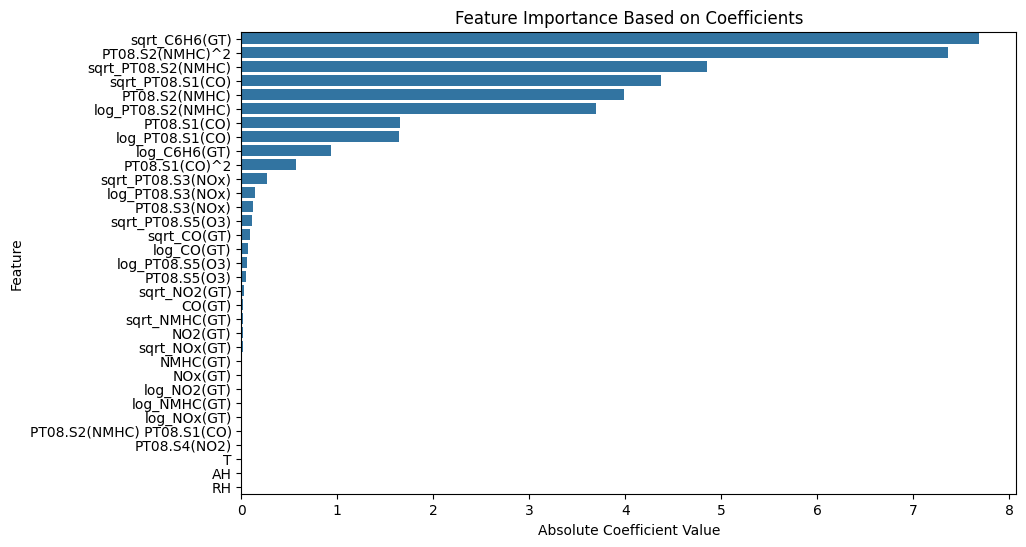

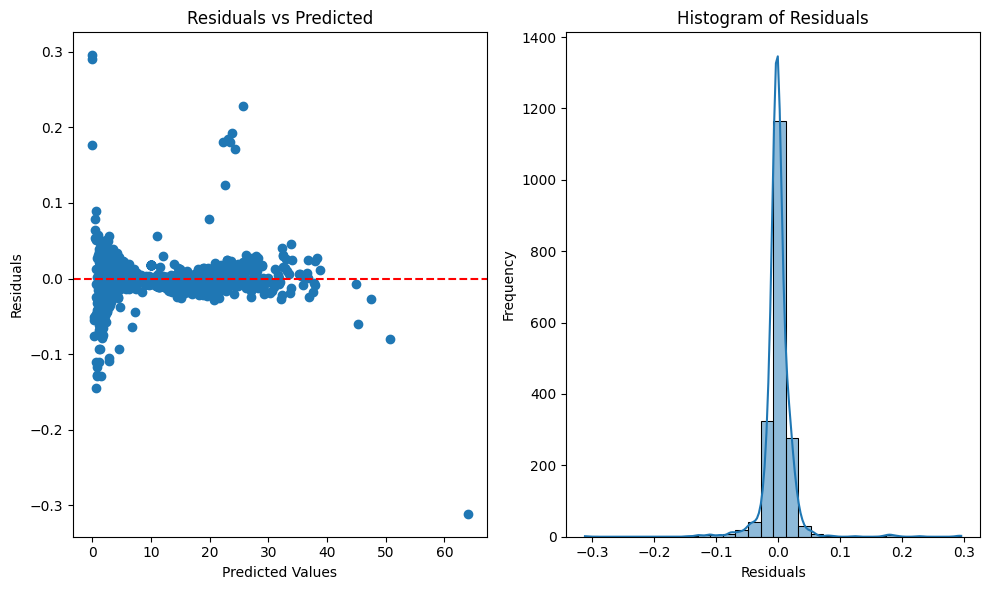

Model Performance:
MSE: 0.0006
RMSE: 0.0248
MAE: 0.0123
R2: 1.0000
Best Alpha: 0.0001

Feature Importance:
                      feature  coefficient  abs_importance
19              sqrt_C6H6(GT)     7.692759        7.692759
32            PT08.S2(NMHC)^2     7.362235        7.362235
21         sqrt_PT08.S2(NMHC)     4.849601        4.849601
15           sqrt_PT08.S1(CO)    -4.374970        4.374970
30              PT08.S2(NMHC)    -3.989239        3.989239
3               PT08.S2(NMHC)    -3.989239        3.989239
20          log_PT08.S2(NMHC)    -3.693341        3.693341
1                 PT08.S1(CO)     1.652804        1.652804
31                PT08.S1(CO)     1.652804        1.652804
14            log_PT08.S1(CO)     1.637714        1.637714
18               log_C6H6(GT)    -0.934190        0.934190
34              PT08.S1(CO)^2    -0.571296        0.571296
25          sqrt_PT08.S3(NOx)    -0.262775        0.262775
24           log_PT08.S3(NOx)     0.141871        0.141871
5       

In [ ]:

def baseline_linear_regression_with_tuning(X, y):
    """
    Perform baseline linear regression with standard preprocessing and hyperparameter tuning.

    Parameters:
    -----------
    X : array-like features
    y : array-like target

    Returns:
    --------
    dict with model performance, hyperparameters, and details
    """
    # 1. Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 2. Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 3. Set up Ridge Regression (for hyperparameter tuning)
    ridge = Ridge()

    # 4. Define hyperparameter grid for tuning
    param_grid = {
        'alpha': np.logspace(-4, 4, 20)  # Range of alpha values for Ridge Regression
    }

    # 5. Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train_scaled, y_train)

    # 6. Best hyperparameters
    best_alpha = grid_search.best_params_['alpha']
    best_model = grid_search.best_estimator_

    # 7. Predictions and evaluation
    y_pred = best_model.predict(X_test_scaled)

    # Performance metrics
    performance = {
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Best Alpha': best_alpha
    }

    # 8. Feature Importance (coefficients from the best model)
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_model.coef_,
        'abs_importance': np.abs(best_model.coef_)
    }).sort_values('abs_importance', ascending=False)

    # 9. Visualization of feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='abs_importance', y='feature', data=feature_importance)
    plt.title('Feature Importance Based on Coefficients')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.show()

    # 10. Residual Analysis
    residuals = y_test - y_pred

    # Plot Residuals vs Predicted
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs Predicted')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')

    # Plot histogram of residuals
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, bins=30)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return {
        'model': best_model,
        'performance': performance,
        'feature_importance': feature_importance,
        'scaler': scaler
    }

target_column = 'C6H6(GT)'

X = df.drop(columns=[target_column, 'Date', 'Time'])
y = df[target_column]

# Run baseline linear regression with hyperparameter tuning
results = baseline_linear_regression_with_tuning(X, y)

# Print performance metrics
print("Model Performance:")
for metric, value in results['performance'].items():
    print(f"{metric}: {value:.4f}")

# Print feature importance
print("\nFeature Importance:")
print(results['feature_importance'])
